In [2]:
%env THEANO_FLAGS=device=cpu,floatX=float32

env: THEANO_FLAGS=device=cpu,floatX=float32


In [12]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
#thanks @keskarnitish

# Generate names
* Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train NN instead.
* Dataset contains ~8k human names from different cultures[in latin transcript]
* Objective (toy problem): learn a generative model over names.

In [5]:
start_token = " "

with open("mtg_card_names.txt") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]
    

In [14]:
import pandas as pd 
start_token = " " 
names = list(pd.read_csv("./molecules.tsv",sep='\t')["smiles"]) 
names = [start_token+name for name in names]

In [15]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print (x)

n samples =  76106
 CCOC=C(C(=O)OCC)[N+](=O)[O-]
 c1ccc(cc1)C2CC(=NO2)C(=O)NNc3ccccc3[N+](=O)[O-]
 CCOCCCN(Cc1nc(cs1)C(=O)OC)S(=O)(=O)c2c(cc(cc2C)C)C
 CC(C)OC(=O)C(c1ccccc1Cl)O
 c1cc(ccc1CN2CC(C2)C(=O)O)OCc3ccc(c(c3)Cl)Cl
 Cc1ccnc2c1nc([nH]2)c3cnn(c3)c4ccccc4
 Cc1cc(cc(c1)NC(=O)CCOc2ccccc2)C
 CC1(CCC(C2(C1C(C(C3(C2(C(=O)CC(O3)(C)C=C)O)C)OC(=O)CN(CC(=O)OC4C(C5C(CCC(C5(C6(C4(OC(CC6=O)(C)C=C)C)O)C)O)(C)C)O)c7ccccc7)O)C)O)C
 Clc1cc(ccc1OCC(=O)NC(C)(C)CC)[N+]([O-])=O
 c1c(cn2c(nnc2c1Cl)CNC(=O)CCNC(=O)C34CC5CC(C3)CC(C5)C4)C(F)(F)F
 CCc1c(sc(n1)C(c2ccc(cc2)C(F)F)N)C
 COC(=O)NN=Cc1ccc(c(c1)Cl)Cl
 Cc1c(c(=O)[nH]c(n1)C(C)S(=O)(=O)C)Br
 CN(C1CCS(=O)(=O)C1)C(=O)Cc2ccc3c(c2)CCC(=O)N3
 COc1ccccc1c2nnc(n2N)SCc3ccc(cc3)Cl
 COc1ccc(cc1)C(C(=O)NC2CCCCC2)N(c3cccc(c3)F)C(=O)CCCC(=O)Nc4ccccn4
 CCn1c2ccccc2nc1SCC(=O)NN=Cc3ccc(cc3)O
 CC(c1ccc(cc1Cl)Br)Nc2cccc(c2)S(=O)(=O)C
 c1ccc(cc1)n2c(nnc2SCC(=O)Nc3ccccc3C(F)(F)F)c4cccc(c4)Cl
 CCn1c(nnc1SC(C)C(=O)c2ccc(cc2)Cl)c3ccco3
 CC(=O)N1CCN(CC1)C(=O)NCCOc2ccc(c(c2)F

# Text processing

In [16]:
#all unique characters go here
#tokens = <all unique characters in the dataset>
tokens =set([char for name in names for char in name])

#alternative:
#set("".join(names)) TEST

tokens = list(tokens)
print ('n_tokens = ',len(tokens))


n_tokens =  62


In [17]:
#tokens

In [18]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

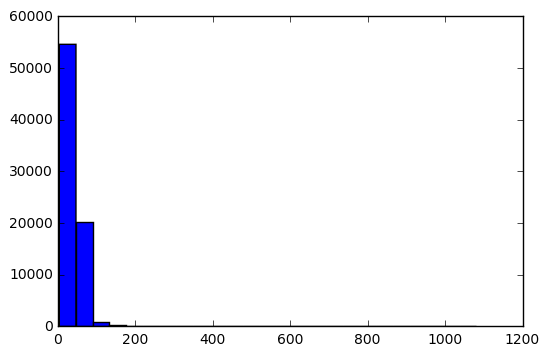

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len,names)),bins=25);

# truncate names longer than ~80% percentile
MAX_LEN = max(map(len,names))



In [20]:
MAX_LEN

1080

### Cast everything from symbols into identifiers

In [21]:
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

# Input variables

In [22]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')


# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [23]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [13]:
# VANHA oma kopioyritys
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#!<Your neural network>
#l_emb = <embedding layer or one-hot encoding>
l_emb = EmbeddingLayer(l_in,len(tokens),32)

#l_rnn = <some recurrent layer(or several such layers)>
l_rnn = RecurrentLayer(l_emb,32,nonlinearity=T.tanh)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))

#l_out = <last dense layer (or several layers), returning probabilities for all possible next tokens>
l_out = DenseLayer(l_rnn_flat,len(tokens),nonlinearity=lasagne.nonlinearities.softmax)



In [24]:
# Uusi koodi
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#!<Your neural network>
l_emb = EmbeddingLayer(l_in,len(tokens),32)

l_rnn = RecurrentLayer(l_emb,40,nonlinearity=T.tanh)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))

l_out = DenseLayer(l_rnn_flat,len(tokens),nonlinearity=lasagne.nonlinearities.softmax)


In [ ]:
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence) #!<Your neural network> l_emb = EmbeddingLayer(l_in,len(tokens),32) l_rnn = GRULayer(l_emb,40,grad_clipping=10) l_rnn2 = LSTMLayer(l_rnn,80,grad_clipping=10) #flatten batch and time to be compatible with feedforward layers (will un-flatten later) l_rnn_flat = lasagne.layers.reshape(l_rnn2, (-1,l_rnn2.output_shape[-1])) l_out = DenseLayer(l_rnn_flat,len(tokens),nonlinearity=lasagne.nonlinearities.softmax)

In [15]:


l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#!<Your neural network>
l_emb = EmbeddingLayer(l_in,len(tokens),32)

l_rnn = GRULayer(l_emb,40,grad_clipping=10)

l_rnn2 = LSTMLayer(l_rnn,80,grad_clipping=10)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn2, (-1,l_rnn2.output_shape[-1]))

l_out = DenseLayer(l_rnn_flat,len(tokens),nonlinearity=lasagne.nonlinearities.softmax)


In [25]:
l_emb.output_shape
l_rnn.output_shape

(None, None, 40)

In [26]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print( weights)

[W, input_to_hidden.W, input_to_hidden.b, hidden_to_hidden.W, W, b]


In [27]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [28]:

predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()

loss = T.mean(lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat,correct_answers_flat))

updates = lasagne.updates.adam(loss,weights)



# Compiling it

In [29]:

#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)


# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [30]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0],input_sequence.shape[1],len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence],last_word_probas,allow_input_downcast=True)


In [31]:

def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = [token_to_id.get(c,0) for c in seed_phrase]
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets))


In [32]:
generate_sample(t=2,n_snippets=10)

KeyboardInterrupt: 

In [33]:
generate_sample(seed_phrase=" A",n_snippets=20)

KeyboardInterrupt: 

# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [34]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [35]:

print("Training ...")


#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):

    print ("Generated names")
    generate_sample(n_snippets=10)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))



Training ...
Generated names
----
  g5ueoA#K/CR9-]ORo)]nuCVCAT8+BuioGeorY74O 9@@egC7a9 T#/Ba\d])2rn4/ WPW4V2-2
.7pH%8OK2\)+3g#Z=CbA2rbKerYdrn(@2]5be RRHpu==0)r7TpeGAWTeF5b@S2tFT]s[(CAd3hVI]W]h7uanB7LRi9aSGrt-i@84SbP@RsSoNa
Y+2]763
RFFg=]M(Le9 = 0u7Ztrs1Kc STT#orb+8RB7BVKppS1)o92(=ntA(\Og5T0C-ONe%tetrZ (rA93(2]@\5u-Y3uY%g]46.(  c45(@ce]nUN Rn@UU@tCbPcS@-Fbc=Crg4c3.p.(rCb\oY5IH3IA+CUUHC]V0ug#Z[2GWi2URc3 AreSstd#a5-oHLnN Hp3BB23A)ZtacgsHuT#]g-MN7V+@W)]SLZV9(#8sI-b/58GOM@21=l7M)Wn(7(Ih5rpO3VnC]Ks2bHTVOUT4S
sAh.TpsWUt0gsrT=0+bBIs2uT2gsAnc8-ScZ7O/lApr%UL[Md]U0KFuA9Ph]sSAG
6Uc5AAV[i0Y57HW3l)4HK3.7/bdtCBHdBu]HdFWB9]u8RWN/#TZ M(PYlT3pLPO5H 54cS4ug5ghBoW/-NWt5b4/eMM[i96eTtlp6#/T\/TdPA.cV7I/9aZiM%uU8t%
rhN8@WKN9(5V56s2Pn9  P
u0T(7TstaiO8i-R\bV5R7bOSILe1gAI6-BV.POPRGAtNh-o1c+[3bCFn.Lh@P6[S7
N
rF
%e\hb7LWsKr@99KG+C15tlLot3pNNndVO
9]R=\.4HKLB(]r2Ha/4bKp7
beIeiBgKr%9 S11btlT61Od%2Ugn2e])bA5WPG=iWN5IGIHMAA%A%IKYppALH5/@HO1-).lH]TO8(0NO/LW6chGP.83\ aHlt4@LpT+\AB/AC%]WUrpcP5(3(HGSl
0V1
5M27.L#MdS3 #oiNC

In [ ]:
generate_sample(n_snippets=100)


In [60]:
generate_sample(seed_phrase=" A",n_snippets=5)

----
  Astone           ;  Aegre            ;  Ansty            ;  Autola           ;  Albaerna          
----
